# Essay Writer Agent

An expert writer tasked with writing a an essay.

Workdflow:

Plan -> Research plan -> Generate -> Either Finish or Reflect -> Reflect critique -> Generate -> Finish

In [1]:
from langgraph.graph import StateGraph, END

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_community.tools.tavily_search import TavilySearchResults

from dotenv import load_dotenv
load_dotenv()

/Users/rachneet/projects/agents_experimental/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Next-80B-A3B-Instruct",
    max_new_tokens=1024,
    temperature=0,
    provider="together"
)

chat_model = ChatHuggingFace(
    llm=llm,
    )

In [3]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# memory = SqliteSaver.from_conn_string(":memory:")
conn = sqlite3.connect("essay_agent.db", check_same_thread=False)
memory = SqliteSaver(conn)

In [4]:
from typing import List, TypedDict

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

## Agent Prompts

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [6]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

In [10]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [12]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = chat_model.invoke(messages)
    print("Plan Response:", response)
    return {"plan": response.content}

In [ ]:
def research_plan_node(state: AgentState):
    queries = chat_model.bind_tools(tools=[Queries]).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    
    # Extract tool calls from the AIMessage
    if queries.tool_calls:
        for tool_call in queries.tool_calls:
            # Parse the arguments to get the Queries object
            query_list = tool_call['args']['queries']  # Adjust based on your Queries schema
            
            for q in query_list:
                response = tavily.search(query=q, max_results=2)
                for r in response['results']:
                    content.append(r['content'])
    
    return {"content": content}

In [27]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = chat_model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [28]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = chat_model.invoke(messages)
    return {"critique": response.content}

In [37]:
def research_critique_node(state: AgentState):
    queries = chat_model.bind_tools(tools=[Queries]).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    # Extract tool calls from the AIMessage
    if queries.tool_calls:
        for tool_call in queries.tool_calls:
            # Parse the arguments to get the Queries object
            query_list = tool_call['args']['queries']  # Adjust based on your Queries schema
            
            for q in query_list:
                response = tavily.search(query=q, max_results=2)
                for r in response['results']:
                    content.append(r['content'])
    
    return {"content": content}

In [38]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [39]:
builder = StateGraph(AgentState)
builder.add_node("planner", research_plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [40]:
builder.set_entry_point("planner")

In [41]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [42]:
graph = builder.compile(checkpointer=memory)

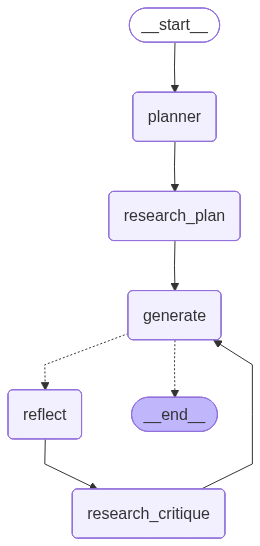

In [43]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
thread = {"configurable": {"thread_id": "1"}}

for s in graph.stream({
    "task": "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
    "plan": "",
    "draft": "",
    "critique": "",
    "content": [] 
}, thread
):
    print(s)

{'planner': {'content': ['In LLM application development, LangChain and LangSmith have become central tools for building and managing large language model-powered solutions. This article compares LangChain and LangSmith, focusing on their core features, integration options, and value for developers in the LLM application space. **Overview:**LangChain is an open-source framework that helps developers create LLM applications efficiently. LangSmith provides tools to debug, monitor, and improve LLM-powered agents, and offers a managed cloud service with a web UI. | LLM Evaluation | Minimal built-in support; developers typically create custom logic or use external tools. LangChain provides building blocks for LLM applications, while LangSmith offers observability and evaluation. LangChain is open-source and free, while LangSmith follows a freemium model for managed services.', 'If you’re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor 